<a href="https://colab.research.google.com/github/milanpavikevik/Skin-Lesion-Classification/blob/main/Skin_Types_52%25-fine-tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, MaxPool2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


testiraj golemina na slika 768x768 , 512x512 , 384x384 , 256x256 , 192x192

In [10]:
INPUT_DIR = '/content/drive/MyDrive/Skin-Lesion/**'
 
dataset = []
for filename in glob.iglob(INPUT_DIR):
    kolkuPoKlasa=0
    print(filename)
    for f in glob.iglob(filename+'/**'):
      #print(f)
      kolkuPoKlasa+=1
      if (kolkuPoKlasa > 1000):
        kolkuPoKlasa=0
        break
        
    
      
      image= cv2.imread( f, cv2.COLOR_BGR2RGB)
      image=cv2.resize(image, (256, 256),interpolation = cv2.INTER_AREA)
      image=np.array(image)
      image = image.astype('float32')
      image /= 255 
      
      class_name = filename.split('/')[-1]
      
      dataset.append([image,class_name])
      
      
    



/content/drive/MyDrive/Skin-Lesion/BCC
/content/drive/MyDrive/Skin-Lesion/DF
/content/drive/MyDrive/Skin-Lesion/AK
/content/drive/MyDrive/Skin-Lesion/BKL
/content/drive/MyDrive/Skin-Lesion/NV
/content/drive/MyDrive/Skin-Lesion/VASC
/content/drive/MyDrive/Skin-Lesion/MEL
/content/drive/MyDrive/Skin-Lesion/SCC


In [38]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
x_train = []
y_train = []
for img,klasa in train:
  x_train.append(img)
  y_train.append(klasa)

x_test = []
y_test = []
for img,klasa in test[:int(len(test)*0.5)]:
  x_test.append(img)
  y_test.append(klasa)


x_val = []
y_val = []
for img,klasa in test[int(len(test)*0.5):]:
  x_val.append(img)
  y_val.append(klasa)

print(len(x_train),len(y_train))
print(len(y_test),len(y_test))
print(len(x_val),len(y_val))

encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)

y_test =  encoder.transform(y_test)
y_val =   encoder.transform(y_val)


class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


class_weights = {i : class_weights[i] for i in range(8)}

print(class_weight)

x_test = np.asarray(x_test)
x_val = np.asarray(x_val)
x_train = np.asarray(x_train)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 3)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

print("X validation:", x_val.shape)
print("Y validation:", y_val.shape)

print(class_weights)

4789 4789
599 599
599 599
<module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>
X train: (4789, 256, 256, 3)
Y train: (4789, 8)
X test: (599, 256, 256, 3)
Y test: (599, 8)
X validation: (599, 256, 256, 3)
Y validation: (599, 8)
{0: 0.8479107648725213, 1: 0.7596763959390863, 2: 0.7492177722152691, 3: 3.401278409090909, 4: 0.7363161131611317, 5: 0.7436335403726708, 6: 1.2093434343434344, 7: 2.8919082125603865}


5987


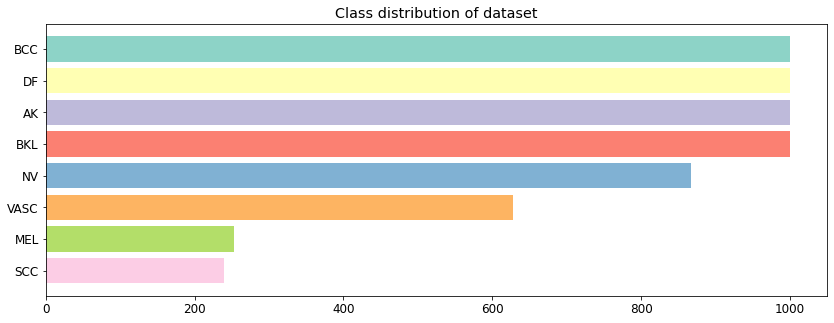

In [45]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
from matplotlib import pyplot as plt

num_classes = 8

xlass=[]

for row in dataset:
  xlass.append(row[1])
print(len(xlass))
xlass = pd.DataFrame(xlass)

class_counts = xlass.value_counts()
cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
colors = [cmap(i) for i in range(num_classes)]

plt.barh(range(num_classes)[::-1], class_counts, tick_label=xlass[0].unique(),
         color=colors)
plt.title('Class distribution of dataset')
plt.show()

xlass=[]


In [39]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 64)      

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=130,
                    validation_data=(x_val, y_val),
                    class_weight=class_weights)


model_name = "/content/skin-classical.h5"
model.save(model_name)


Epoch 1/130
38/38 [==============================] - 128s 3s/step - loss: 1.9706 - accuracy: 0.2076 - val_loss: 1.9536 - val_accuracy: 0.2154
Epoch 2/130
38/38 [==============================] - 131s 3s/step - loss: 1.9199 - accuracy: 0.2236 - val_loss: 1.9228 - val_accuracy: 0.2404
Epoch 3/130
38/38 [==============================] - 127s 3s/step - loss: 1.9167 - accuracy: 0.2193 - val_loss: 1.9168 - val_accuracy: 0.2304
Epoch 4/130
38/38 [==============================] - 129s 3s/step - loss: 1.8940 - accuracy: 0.2360 - val_loss: 1.8989 - val_accuracy: 0.2104
Epoch 5/130
38/38 [==============================] - 127s 3s/step - loss: 1.8861 - accuracy: 0.2458 - val_loss: 1.8927 - val_accuracy: 0.2321
Epoch 6/130
38/38 [==============================] - 127s 3s/step - loss: 1.8631 - accuracy: 0.2506 - val_loss: 1.9088 - val_accuracy: 0.2053
Epoch 7/130
38/38 [==============================] - 128s 3s/step - loss: 1.8596 - accuracy: 0.2600 - val_loss: 1.8540 - val_accuracy: 0.2471
Epoch 

In [ ]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

In [12]:
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(8, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')



In [13]:
history1 = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


model_name = "/content/skin-type-1.h5"
model.save(model_name)

Epoch 1/10
38/38 [==============================] - 1976s 52s/step - loss: 6.9064 - accuracy: 0.1548 - val_loss: 2.0622 - val_accuracy: 0.1436
Epoch 2/10
Epoch 2/10
38/38 [==============================] - 1896s 50s/step - loss: 1.9537 - accuracy: 0.1754 - val_loss: 2.0376 - val_accuracy: 0.1486
Epoch 3/10
Epoch 3/10
38/38 [==============================] - 1911s 50s/step - loss: 1.9217 - accuracy: 0.2030 - val_loss: 2.0407 - val_accuracy: 0.1386
Epoch 4/10
Epoch 4/10
38/38 [==============================] - 1891s 50s/step - loss: 1.9180 - accuracy: 0.2287 - val_loss: 2.0201 - val_accuracy: 0.1369
Epoch 5/10
Epoch 5/10
38/38 [==============================] - 1881s 50s/step - loss: 1.8863 - accuracy: 0.2482 - val_loss: 1.9558 - val_accuracy: 0.2137
Epoch 6/10
Epoch 6/10
38/38 [==============================] - 1893s 50s/step - loss: 1.8627 - accuracy: 0.2596 - val_loss: 1.9403 - val_accuracy: 0.1836
Epoch 7/10
Epoch 7/10
38/38 [==============================] - 1874s 49s/step - loss: 1

In [14]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

19/19 [==============================] - 54s 3s/step
              precision    recall  f1-score   support

          AK       0.37      0.30      0.33        96
         BCC       0.52      0.34      0.41       171
         BKL       0.22      0.25      0.23        91
          DF       0.00      0.00      0.00         0
         MEL       0.18      0.57      0.27        28
          NV       0.49      0.40      0.44       124
         SCC       0.36      0.28      0.32        74
        VASC       0.32      0.47      0.38        15

    accuracy                           0.34       599
   macro avg       0.31      0.33      0.30       599
weighted avg       0.40      0.34      0.36       599

              precision    recall  f1-score   support

          AK       0.37      0.30      0.33        96
         BCC       0.52      0.34      0.41       171
         BKL       0.22      0.25      0.23        91
          DF       0.00      0.00      0.00         0
         MEL       0.18  

hyper-tuning

In [15]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [23]:
from keras.utils import to_categorical

vgg_features_train = pretrained_model.predict(x_train)
vgg_features_val = pretrained_model.predict(x_val)

ValueError: ignored

In [20]:
train_target = y_train
val_target = y_val

In [34]:
from keras.layers.normalization import BatchNormalization
model2 = Sequential()
model2.add(Flatten(input_shape=(8,8,512)))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(8, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model2.summary()

# train model using features generated from VGG16 model
model2.fit(vgg_features_train, train_target, epochs=100, batch_size=128, validation_data=(vgg_features_val, val_target),class_weight=class_weights)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3276900   
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 808       
Total params: 3,278,108
Trainable params: 3,277,908
Non-trainable params: 200
_________________________________________________________________
Epoch 1/100
38/38 [==============================] - 3s 70ms/step - loss: 2.2400 - accuracy: 0.1770 - val_lo

In [35]:
vgg_features_test = pretrained_model.predict(x_test)

predictions = model2.predict(vgg_features_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

19/19 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

          AK       0.51      0.47      0.48        86
         BCC       0.58      0.56      0.57       115
         BKL       0.52      0.47      0.50       117
          DF       0.33      0.44      0.38        25
         MEL       0.51      0.52      0.51        89
          NV       0.49      0.53      0.51        92
         SCC       0.64      0.58      0.61        65
        VASC       0.41      0.90      0.56        10

    accuracy                           0.52       599
   macro avg       0.50      0.56      0.52       599
weighted avg       0.53      0.52      0.52       599

